# MCMC5.0: Exact Diagonalization and Thermal Pure Quantum States

To search for the ground state of the physical Hamiltonian, we do not need to diagonalize the Hamiltonian completely. It is enough to find an eigenstate with the lowest energy. Such a partial problem can be solved by iterative methods. This alrogithm may also works for finite temperatures.

## Sparse matrix revisited

As seen in MCMC2.5, Julia does not natively support the diagonalization of the sparse matrix, so we need a package called Arpack.jl or ArnoldiMethod.jl. I strongly recommend using ArnoldiMethod.jl because Arpack does not support Intel MKL BLAS and causes a problem in installation.

In [1]:
using ArnoldiMethod
const A = rand(10, 10)

10×10 Array{Float64,2}:
 0.829716   0.476287  0.417265  0.347584  …  0.110532  0.0715179   0.328459  
 0.938976   0.607937  0.334985  0.326869     0.255805  0.724799    0.761819  
 0.0052708  0.217807  0.977191  0.297425     0.884543  0.00895307  0.00974007
 0.249313   0.609089  0.522609  0.781418     0.779706  0.132115    0.282143  
 0.106795   0.530788  0.280875  0.128662     0.480256  0.544074    0.386118  
 0.0360849  0.895739  0.337535  0.324562  …  0.413068  0.0919578   0.783636  
 0.895318   0.800111  0.321419  0.472407     0.85468   0.537896    0.287101  
 0.631663   0.942614  0.987678  0.657799     0.477155  0.554867    0.196418  
 0.920056   0.11712   0.520464  0.689725     0.485385  0.815888    0.36948   
 0.923096   0.278292  0.462442  0.560704     0.618867  0.568418    0.567208  

In [2]:
decomp, history = partialschur(A; nev = 2)
decomp

PartialSchur decomposition (Float64) of dimension 3
eigenvalues:
3-element Array{Complex{Float64},1}:
   4.839162274509493 + 0.0im             
 0.14000308803027173 + 1.10944362642812im
 0.14000308803027173 - 1.10944362642812im

In [3]:
using LinearAlgebra
eigvals(A)

10-element Array{Complex{Float64},1}:
    4.839162274509496 + 0.0im                
  0.14000308803027198 + 1.109443626428121im  
  0.14000308803027198 - 1.109443626428121im  
 -0.24726064172715678 + 0.10573813927282762im
 -0.24726064172715678 - 0.10573813927282762im
  0.19535159306368297 + 0.2315542410232878im 
  0.19535159306368297 - 0.2315542410232878im 
   0.9282703780180047 + 0.0im                
   0.6078858781328046 + 0.1333598571897889im 
   0.6078858781328046 - 0.1333598571897889im 

It is clear that `partialschur` takes 2 pairs of the whole eigenvalues approximately (almost exactly). Such iterative methods is important in the case we do not need every spectrum.

More importantly, ArnoldiMethod.jl and Arpack.jl support sparse matrices (and even abstract `LinearMaps`), so the diagonalization of sparse matrices becomes very fast.

In [4]:
using SparseArrays
const B = sprand(1000, 1000, 0.01)

1000×1000 SparseMatrixCSC{Float64,Int64} with 9997 stored entries:
  [220 ,    1]  =  0.401152
  [290 ,    1]  =  0.315422
  [338 ,    1]  =  0.408143
  [515 ,    1]  =  0.772379
  [601 ,    1]  =  0.701451
  [610 ,    1]  =  0.416941
  [622 ,    1]  =  0.550713
  [696 ,    1]  =  0.0480208
  [940 ,    1]  =  0.806804
  [121 ,    2]  =  0.790392
  [309 ,    2]  =  0.371609
  [336 ,    2]  =  0.461124
  ⋮
  [118 , 1000]  =  0.63167
  [227 , 1000]  =  0.0269682
  [439 , 1000]  =  0.971861
  [470 , 1000]  =  0.450831
  [482 , 1000]  =  0.337391
  [604 , 1000]  =  0.313621
  [627 , 1000]  =  0.400695
  [644 , 1000]  =  0.173406
  [677 , 1000]  =  0.987037
  [889 , 1000]  =  0.950529
  [917 , 1000]  =  0.495041
  [952 , 1000]  =  0.538334

In [5]:
decomp, history = partialschur(B; nev = 2)
decomp

PartialSchur decomposition (Float64) of dimension 2
eigenvalues:
2-element Array{Complex{Float64},1}:
  5.023882038092268 + 0.0im
 -1.900650284219158 + 0.0im

In [6]:
eigvals(Array(B))

1000-element Array{Complex{Float64},1}:
    5.023882038276584 + 0.0im                 
   1.8207279432950547 + 0.22470380479892973im 
   1.8207279432950547 - 0.22470380479892973im 
   1.5357361698628993 + 1.0637776362887803im  
   1.5357361698628993 - 1.0637776362887803im  
   1.7289644635014612 + 0.4709619878799976im  
   1.7289644635014612 - 0.4709619878799976im  
  -1.9006502810839498 + 0.0im                 
   1.2970274052241173 + 1.2332769144770392im  
   1.2970274052241173 - 1.2332769144770392im  
   1.0901753852419462 + 1.429060564248497im   
   1.0901753852419462 - 1.429060564248497im   
   1.1864131840119985 + 1.3198950862048728im  
                      ⋮                       
  0.13498575364324295 + 0.032805743369929585im
  0.13498575364324295 - 0.032805743369929585im
  0.10577535123783524 + 0.09070703926718209im 
  0.10577535123783524 - 0.09070703926718209im 
 -0.13961519350545287 + 0.0im                 
 -0.03933545662513853 + 0.11532647719696898im 
 -0.0393354566251385

If you only need a few eigenvalues and eigenstates, `partialschur` is much faster.

## Exact diagonalization of many-body Hamiltonians

~ under construction ~

In [7]:
function openhoneycomb(Lx::Int64, Ly::Int64)::Tuple
    N = 2Lx * Ly
    nnx = zip(1 : 2 : (N - 1), 2 : 2 : N)
    nny = Iterators.flatten((zip((1 + 2i) : 2Lx : (2Lx * (Ly - 1)  + 1 + 2i), 2i : 2Lx : (2Lx * (Ly - 1)  + 2i)) for i in 1 : (Lx - 1)))
    nnz = zip(1 : 2 : (N - 1), Iterators.flatten(((2Lx + 2) : 2 : N, 2 : 2 : 2Lx)))
    N, nnx, nny, nnz
end

openhoneycomb (generic function with 1 method)

~ under construction ~

In [8]:
const σx = sparse(ComplexF64[0.0 1.0; 1.0 0.0])
const σy = sparse(ComplexF64[0.0 -1.0im; 1.0im 0.0])
const σz = sparse(ComplexF64[1.0 0.0; 0.0 -1.0])

2×2 SparseMatrixCSC{Complex{Float64},Int64} with 2 stored entries:
  [1, 1]  =  1.0+0.0im
  [2, 2]  =  -1.0+0.0im

In order to create $ I_1 \otimes I_2 \otimes \dots \otimes \sigma_i \otimes \dots \otimes I_{N-1} \otimes I_N$, we use the following code.

In [9]:
"""
Returning Pauli operators at ith site

σ must be a Pauli matrix
"""
function spinoperators(σ::SparseMatrixCSC{ComplexF64,Int64}, i::Int64, N::Int64)::SparseMatrixCSC{ComplexF64,Int64}
    if N < 1
        throw(DomainError(N, "argument must be positive"))
    elseif i == 1 && N == 1
        σ
    elseif N == 1
        sparse(I, 2, 2)
    elseif i == N
        kron(spinoperators(σ, i, N - 1), σ)
    else
        kron(spinoperators(σ, i, N - 1), sparse(I, 2, 2))
    end
end
Array(spinoperators(σx, 2, 2))

4×4 Array{Complex{Float64},2}:
 0.0+0.0im  1.0+0.0im  0.0+0.0im  0.0+0.0im
 1.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  1.0+0.0im
 0.0+0.0im  0.0+0.0im  1.0+0.0im  0.0+0.0im

This is a slow recursive code, but it does not matter for our purpose. Actually, in this case, two Kronecker products are enough.

**Exercise1**: Rewrite `spinoperators` not using a loop or recursion.

In [10]:
N, nnx, nny, nnz = openhoneycomb(2, 2)
σi = map(x -> spinoperators(x..., N), Iterators.product([σx, σy, σz], 1 : N));

Now a many-body Hamiltonian can be constructed simply.

In [11]:
const Jx = 1 / 3
const Jy = 1 / 3
const Jz = 1 / 3
const D = 1 << N
H = spzeros(Float64, D, D)
for (J, nn, σlist) in zip([Jx, Jy, Jz], [nnx, nny, nnz], [σi[1, :], σi[2, :], σi[3, :]])
    for bond in nn
        H += J * real.(σlist[bond[1]] * σlist[bond[2]])
    end
end
H

256×256 SparseMatrixCSC{Float64,Int64} with 1696 stored entries:
  [1  ,   1]  =  1.33333
  [4  ,   1]  =  0.333333
  [7  ,   1]  =  -0.333333
  [13 ,   1]  =  0.333333
  [49 ,   1]  =  0.333333
  [97 ,   1]  =  -0.333333
  [193,   1]  =  0.333333
  [2  ,   2]  =  0.666667
  [3  ,   2]  =  0.333333
  [8  ,   2]  =  -0.333333
  [14 ,   2]  =  0.333333
  [50 ,   2]  =  0.333333
  ⋮
  [207, 255]  =  0.333333
  [243, 255]  =  0.333333
  [249, 255]  =  -0.333333
  [254, 255]  =  0.333333
  [255, 255]  =  0.666667
  [64 , 256]  =  0.333333
  [160, 256]  =  -0.333333
  [208, 256]  =  0.333333
  [244, 256]  =  0.333333
  [250, 256]  =  -0.333333
  [253, 256]  =  0.333333
  [256, 256]  =  1.33333

For simplicity, here I use full exact diagonalization, but you can also use partial methods.

In [12]:
#decomp, history = partialschur(H, nev = 200, which = SR(), tol=1e-5)
#E, φ = partialeigen(decomp)
E = eigvals(Hermitian(Array(H)))
Esorted = sort(real.(E), rev=true)

256-element Array{Float64,1}:
  2.0000000000000044
  2.000000000000003 
  2.0000000000000027
  2.000000000000001 
  1.7632326996322463
  1.7632326996322463
  1.7632326996322456
  1.763232699632244 
  1.7632326996322432
  1.7632326996322432
  1.763232699632243 
  1.7632326996322425
  1.7632326996322423
  ⋮                 
 -1.7632326996322423
 -1.7632326996322423
 -1.7632326996322423
 -1.7632326996322425
 -1.7632326996322432
 -1.7632326996322434
 -1.7632326996322454
 -1.7632326996322456
 -1.9999999999999976
 -1.9999999999999982
 -2.000000000000003 
 -2.0000000000000036

In [13]:
Z(E::Vector{Float64}) = β::Float64 -> sum(@. exp(-β * E))
intE(E::Vector{Float64}) = β::Float64 -> sum(@. E * exp(-β * E)) / Z(E)(β)
intE²(E::Vector{Float64}) = β::Float64 -> sum(@. (E ^ 2) * exp(-β * E)) / Z(E)(β)
Cv(E::Vector{Float64}) = β::Float64 -> β ^ 2 * (intE²(E)(β) - intE(E)(β) ^ 2)
Cv(Esorted)(10.0)

1.4791528705237589

For this problem (N = 8), it is ok to use `eigvals`, but if N > 12, it is already difficult to use `eigvals`.

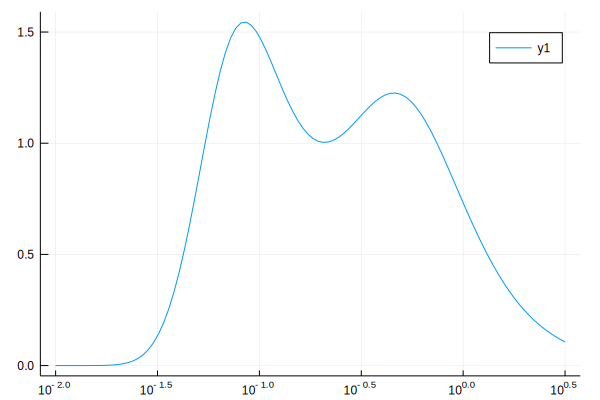

In [14]:
using Plots; gr()
βs = exp.(log(10) * collect(range(-0.5, stop = 2.0, length = 100)))
plot(1 ./ βs, map(Cv(Esorted), βs); xscale = :log10)

The difference from the original paper comes from the difference in the boundary conditions.

**Exercise2**: try to do the same approximation in Kitaev model QMC, and check whether it is efficient or not.

## LOBPCG method

The locally optimal block preconditioned conjugate gradient (LOBPCG) method is another algorithm to find out the lowest eigenvalue (and its eigenvector). The method is based on the iterative CG method (see MCMC2.5).

In [15]:
using IterativeSolvers

LOBPCG is implemented in IterativeSolvers.jl.

In [16]:
r = lobpcg(H, false, 10)
r.λ

10-element Array{Float64,1}:
 -1.999999999936395 
 -1.9999999998971298
 -1.9999999998025757
 -1.9999999996947273
 -1.7632326995988519
 -1.763232699573741 
 -1.7632326994198009
 -1.7632326993192382
 -1.7632326991441072
 -1.7632326990321496

## Thermal pure quantum (TPQ) state

If you wish to plot the heat capacity for a large system, it is recommended to use TPQ states instead of the exact diagonalization. Currently, the easiest way is to install HPhi: https://github.com/issp-center-dev/HPhi.

However, I will show a simple implementation of the calculation of TPQ states. The calculation of TPQ states is very much related to exact diagonalization because they are both using Krylov subspace methods and TPQ states are calculated by almost the same computational cost as that for the ground state. Both calculations use the sparsity of the Hamiltonian intensively.

### Finite-temperature microcanonical TPQ (mTPQ) state

$l$ is an arbitrary number which has to be greater than the largest eigenvalue of $H / N$.

In [17]:
const l = 1.0

1.0

The calculation of mTPQ is simple. Check the documentation of HPhi.

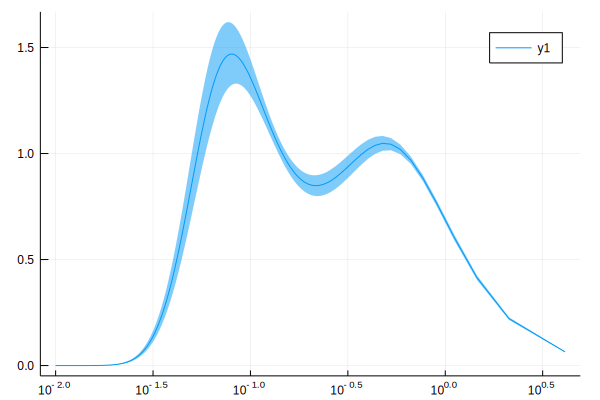

In [18]:
using ResumableFunctions
using Statistics
braket(bra::AbstractVector{T}, ket::AbstractVector{T}) where T = bra' * ket
@resumable function mTPQ(H::AbstractMatrix, ℓ::Float64, N::Int64, D::Int64)::Tuple{Float64, Float64}
    Nstep = 500
    Φtemp = randn(ComplexF64, D)
    Φ =  Φtemp / norm(Φtemp)
    for k in 1 : Nstep
        Φtemp .= (ℓ * I - H / N) * Φ
        Φ .= Φtemp / norm(Φtemp)
        E = braket(Φ, H * Φ)
        β = 2k / N / (ℓ - E / N)
        HΦ = H * Φ
        E² = braket(HΦ, HΦ)
        @yield real(β), real(E² - E * E)
    end
end
function oneshot(H::AbstractMatrix, ℓ::Float64, N::Int64, D::Int64)::Tuple # This is not a good function
    tuples = collect(mTPQ(H, ℓ, N, D))
    first.(tuples), last.(tuples)
end
Nsample = 10
data = [oneshot(H, l, N, D) for i in 1 : Nsample]
βm = mean(first.(data))
βs = stdm(first.(data), βm) / sqrt(Nsample) # the errorbar for β is almost negligible
cvm = mean(last.(data))
cvs = stdm(last.(data), cvm) / sqrt(Nsample)
plot(1 ./ βm, @. βm ^ 2 * cvm; xscale = :log10, ribbon = @. βm ^ 2 * cvs)

### Finite-temperature canonical TPQ (cTPQ) state

Unfortunately, in 2D mTPQ does not produce a correct result. This is due to a finite size effect which is severe in the microcanonical formulation. However, in cTPQ state the finite size effect will be exponentially suppressed, and it is recommended to use this if you want to compare between TPQ states and exact diagonalization. The simplest way is to use an imaginary time evolution, although it only works at moderately high temperature.

First, approximate the exponential until the third order.
$$\exp(-\Delta \tau H) = 1-\Delta \tau H+\frac{1}{2} \Delta \tau^2 H^2 - \frac{1}{3!} \Delta \tau^3 H^3 + O(\Delta \tau^4).$$

In [19]:
M = 10
Δτ = 0.5 / M
ex = I - Δτ * H + (Δτ ^ 2 / 2) * (H ^ 2) - (Δτ ^ 3 / factorial(3)) * (H ^ 3)

256×256 SparseMatrixCSC{Float64,Int64} with 7232 stored entries:
  [1  ,   1]  =  0.936302
  [4  ,   1]  =  -0.0161343
  [7  ,   1]  =  0.0161327
  [10 ,   1]  =  1.54321e-6
  [13 ,   1]  =  -0.0161343
  [16 ,   1]  =  0.000277778
  [49 ,   1]  =  -0.0161343
  [52 ,   1]  =  0.000265432
  [55 ,   1]  =  -0.000271605
  [61 ,   1]  =  0.000277778
  [64 ,   1]  =  -4.62963e-6
  [97 ,   1]  =  0.0161327
  ⋮
  [160, 256]  =  0.0161327
  [193, 256]  =  -4.62963e-6
  [196, 256]  =  0.000277778
  [202, 256]  =  -0.000271605
  [205, 256]  =  0.000265432
  [208, 256]  =  -0.0161343
  [241, 256]  =  0.000277778
  [244, 256]  =  -0.0161343
  [247, 256]  =  1.54321e-6
  [250, 256]  =  0.0161327
  [253, 256]  =  -0.0161343
  [256, 256]  =  0.936302

You can go to an arbitrary large order, but the sparsity will be lost eventually.

cTPQ can be constructed by the imaginary time evolution of the initial state prepared in the same way as mTPQ. I note that differently from mTPQ, you can use $Z_2$ random numbers (i.e. Ising vector) instead if you wish.

In [35]:
function cTPQ(H::AbstractMatrix, M::Int64, D::Int64)::Float64
    Ψtemp = randn(ComplexF64, D)
    Ψ = Ψtemp / norm(Ψtemp)
    for i in 1 : 10M
        Ψ .= ex * Ψ
    end
    real(braket(Ψ, H * Ψ) / braket(Ψ, Ψ))
end
E = [cTPQ(H, M, D) for n in 1 : 100]
m = mean(E)
m, stdm(E, m) / sqrt(100)

(-1.917343982354526, 0.0028718296247965507)

TODO: measure Cv

In [25]:
intE(Esorted)(10.0)

-1.9219877763158921

For a more accurate simulation, resummation (similar to stochastic series expansion) is necessary. See https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.111.010401 for more details.

## Comparison between QMC and ED/TPQ

As for TPQ, it is accurate enough if we take 1000 draws for the initial vector. Let's compare QMC, TPQ and full ED.

### Full ED

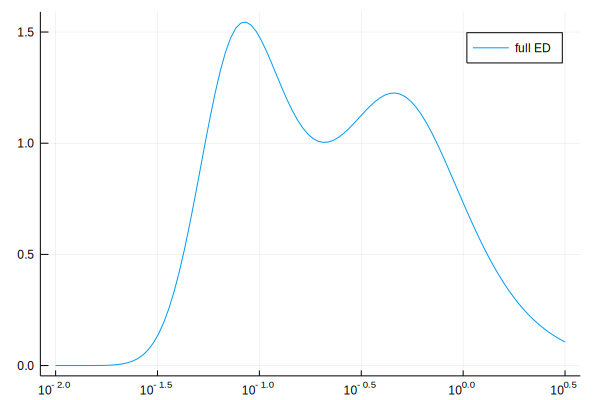

In [20]:
Efull = eigvals(Hermitian(Array(H)))
Efullsorted = sort(Efull, rev=true)
βs = exp.(log(10) * collect(range(-0.5, stop = 2.0, length = 100)))
plot(1 ./ βs, map(Cv(Efullsorted), βs); xscale = :log10, label = ["full ED"])

For this very small system full ED is actually fast enough!

### mTPQ

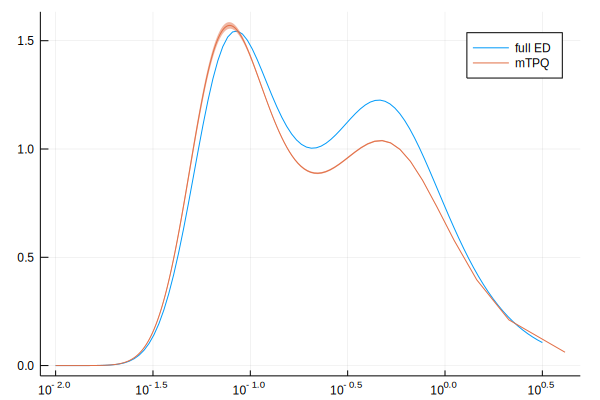

In [21]:
const Naccurate = 1000
data2 = [oneshot(H, l, N, D) for i in 1 : Naccurate]
βm2 = mean(first.(data2))
βs2 = stdm(first.(data2), βm2) / sqrt(Naccurate)
cvm2 = mean(last.(data2))
cvs2 = stdm(last.(data2), cvm2) / sqrt(Naccurate)
plot!(1 ./ βm2, @. βm2 ^ 2 * cvm2; xscale = :log10, label = ["full ED", "mTPQ"], ribbon = @. βm2 ^ 2 * cvs2)

Be careful! mTPQ state never agrees with the exact value for the finite system at high temperature!!! This is because mTPQ state intensively uses typicality of the quantum **many-body** systems, which is only exact in the thermodynamic limit. However, even if we consider such finite-size effects, mTPQ states are doing well especially at low temperature. You can see how good mTPQ states are by `yscale = :log10` option.

## cTPQ

~ under construction ~

## QMC

In [22]:
function Metropolis(βF::Float64, βFnew::Float64)::Bool
    βF - βFnew > log(rand())
end
@resumable function measurementEf(method::Function, lattice::Function, β::Float64, Lx::Int64, Ly::Int64)::Vector{Float64}
    N, nnx, nny, nnz = lattice(Lx, Ly)
    iter = Iterators.flatten((Iterators.product(J, nn) for (J, nn) in [(Jx, nnx), (Jy, nny), (Jz, nnz)]))
    h = spzeros(ComplexF64, N, N)
    for (J, nn) in iter
        h[nn[1], nn[2]] = 2.0im * J
        h[nn[2], nn[1]] = -2.0im * J
    end
    NNz = collect(nnz)
    Nz = length(NNz)
    η = ones(Int64, Nz)
    βF = 0.0
    β₂ = β * 0.5
    hdense = Array(h)
    ev = zeros(Float64, N)
    while true
        for i in 1 : Nz
            j = rand(1 : Nz)
            hdense[NNz[j][1], NNz[j][2]] = -hdense[NNz[j][1], NNz[j][2]]
            hdense[NNz[j][2], NNz[j][1]] = -hdense[NNz[j][2], NNz[j][1]]
            evnew = eigvals(Hermitian(hdense))
            βFnew = -sum(@. log(exp(β₂ * evnew[(N >> 1 + 1) : end]) + exp(-β₂ * evnew[(N >> 1 + 1) : end])))
            if method(βF, βFnew)
                η[j] = -η[j]
                βF = βFnew
                ev .= evnew
            else
                hdense[NNz[j][1], NNz[j][2]] = -hdense[NNz[j][1], NNz[j][2]]
                hdense[NNz[j][2], NNz[j][1]] = -hdense[NNz[j][2], NNz[j][1]]
            end
        end
        Ef = -sum(@. ev[(N >> 1 + 1) : end] * tanh(β₂ * ev[(N >> 1 + 1) : end] )) * 0.5
        ∂Ef∂β = -sum(@. (ev[(N >> 1 + 1) : end] ^ 2) * (sech(β₂ * ev[(N >> 1 + 1) : end]) ^ 2)) * 0.25
        @yield [Ef, ∂Ef∂β]
    end
end

measurementEf (generic function with 1 method)

In [23]:
function leaveoneout(before::Function, after::Function, v::AbstractVector)
    ind = eachindex(v)
    map(i -> after(mean(map(before, view(v, filter(!isequal(i), ind))))), ind)
end
meanJ(b::Function, a::Function, v::AbstractVector) = mean(leaveoneout(b, a, v))
stdmJ(b::Function, a::Function, v::AbstractVector, m) = stdm(leaveoneout(b, a, v), m, corrected = false) * sqrt(length(v) - 1)

stdmJ (generic function with 1 method)

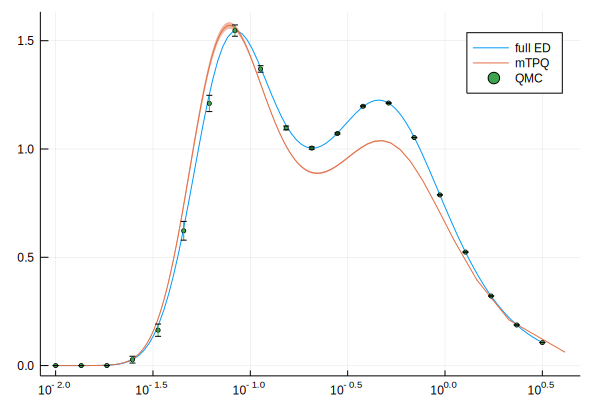

In [24]:
before(v::Vector{Float64}) = [v[1] ^ 2 - v[2], v[1]]
function after(β::Float64)::Function
    β² = β ^ 2
    meanTTCv::Vector{Float64} -> β² * (meanTTCv[1] - meanTTCv[2] ^ 2)
end
βqmc = exp.(log(10) * collect(range(-0.5, stop = 2.0, length = 20)))
function qmc(β::Float64)::Tuple{Float64, Float64}
    mcstep = Iterators.drop(measurementEf(Metropolis, openhoneycomb, β, 2, 2), 2000)
    iter = Iterators.take(mcstep, 10000)
    data = collect(iter)
    m = meanJ(before, after(β), data)
    s = stdmJ(before, after(β), data, m)
    m, s
end
results = qmc.(βqmc)
scatter!(1 ./ βqmc, first.(results), yerror = last.(results); xscale = :log10, markersize = 2, label = ["full ED", "mTPQ", "cTPQ", "QMC"])

QMC results completely agree with full ED within the errorbars! Note that the values at low temperature is correct only with replica exchange Monte Carlo.